In [2]:
import os
import sys
sys.path.append("../")
import pathlib
import pylab as plt

import h5py
import numpy as np
import fastmri
from fastmri.data import transforms as T
from fastmri.data.subsample import RandomMaskFunc, EquispacedMaskFunc
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
from torch.nn import functional as F

import pytorch_lightning as pl
from fastmri.data.mri_data import fetch_dir
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.data.transforms import UnetDataTransform
from fastmri.pl_modules import FastMriDataModule, UnetModule, MriModule
from cviaaiFMRI.utils.models import EnetModelPL, UnetSMPModelPL
pl.seed_everything(42)

sys.path.append('../../fastmri_examples/cs/')
sys.path.append('../../../bart-0.6.00/python/')
os.environ['TOOLBOX_PATH'] = os.path.abspath('../../../bart-0.6.00/')
from run_bart import SliceDataset, DataTransform, run_model, cs_total_variation

class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [3]:
file_name = '../../../fastMRIdatasets/singlecoil_val/file1000052.h5'
hf = h5py.File(file_name)
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPD_FBK', 'max': 0.0007207574118101356, 'norm': 0.18467329268499744, 'patient_id': 'aec97d55e8719bc06b7b23b82ca97c3e3ef351a4a0279c7169e32707fe4a958c'}
complex64
(38, 640, 372)


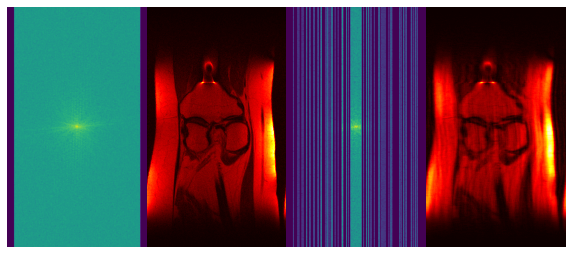

In [4]:
slice_kspace = T.to_tensor(volume_kspace[25])
slice_image = fastmri.ifft2c(slice_kspace)
slice_image_abs = fastmri.complex_abs(slice_image)

mask_func = RandomMaskFunc(center_fractions=[0.08], accelerations=[4])
# mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])
# mask_func = EquispacedMaskFunc(center_fractions=[0.01], accelerations=[8])
masked_kspace, mask = T.apply_mask(slice_kspace, mask_func)
sampled_image = fastmri.ifft2c(masked_kspace)
sampled_image_abs = fastmri.complex_abs(sampled_image)
fig, ax = plt.subplots(ncols=4, figsize=(10,10),
                       subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                       gridspec_kw=dict(wspace=0.0, hspace=0.0))
ax[0].imshow(np.log(np.abs(volume_kspace[20]) + 1e-9))
ax[1].imshow(np.abs(slice_image_abs), cmap='hot')
ax[2].imshow(np.log(np.abs(masked_kspace[:,:,0]) + 1e-9))
ax[3].imshow(np.abs(sampled_image_abs), cmap='hot')
plt.show()

In [5]:
enet_model = EnetModelPL.load_from_checkpoint('../models/enet-unnamed/checkpoints/epoch=0.ckpt')
models = [
    (enet_model, 'Enet'),
]

In [6]:
slice_image_abs = fastmri.complex_abs(fastmri.data.transforms.complex_center_crop(slice_image, (320, 320)))
sampled_image = fastmri.data.transforms.complex_center_crop(sampled_image, (320, 320))
sampled_image_abs = fastmri.complex_abs(sampled_image)
std = sampled_image_abs.std()
mean = sampled_image_abs.mean()
sampled_image_n = (sampled_image_abs - mean) / (std + 1e-11)
predictions = []
for i, (model, name) in tqdm(enumerate(models), total=len(models)):
    reconstructed_image = model(sampled_image_n.unsqueeze(0))[0].detach()
    reconstructed_image = (reconstructed_image * std) + mean
    predictions += [(reconstructed_image, name)]
# args = Namespace(challenge='singlecoil', num_iters=400)
# predictions += [(cs_total_variation(args, masked_kspace, 0.01, (320, 320), None), 'CS')]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


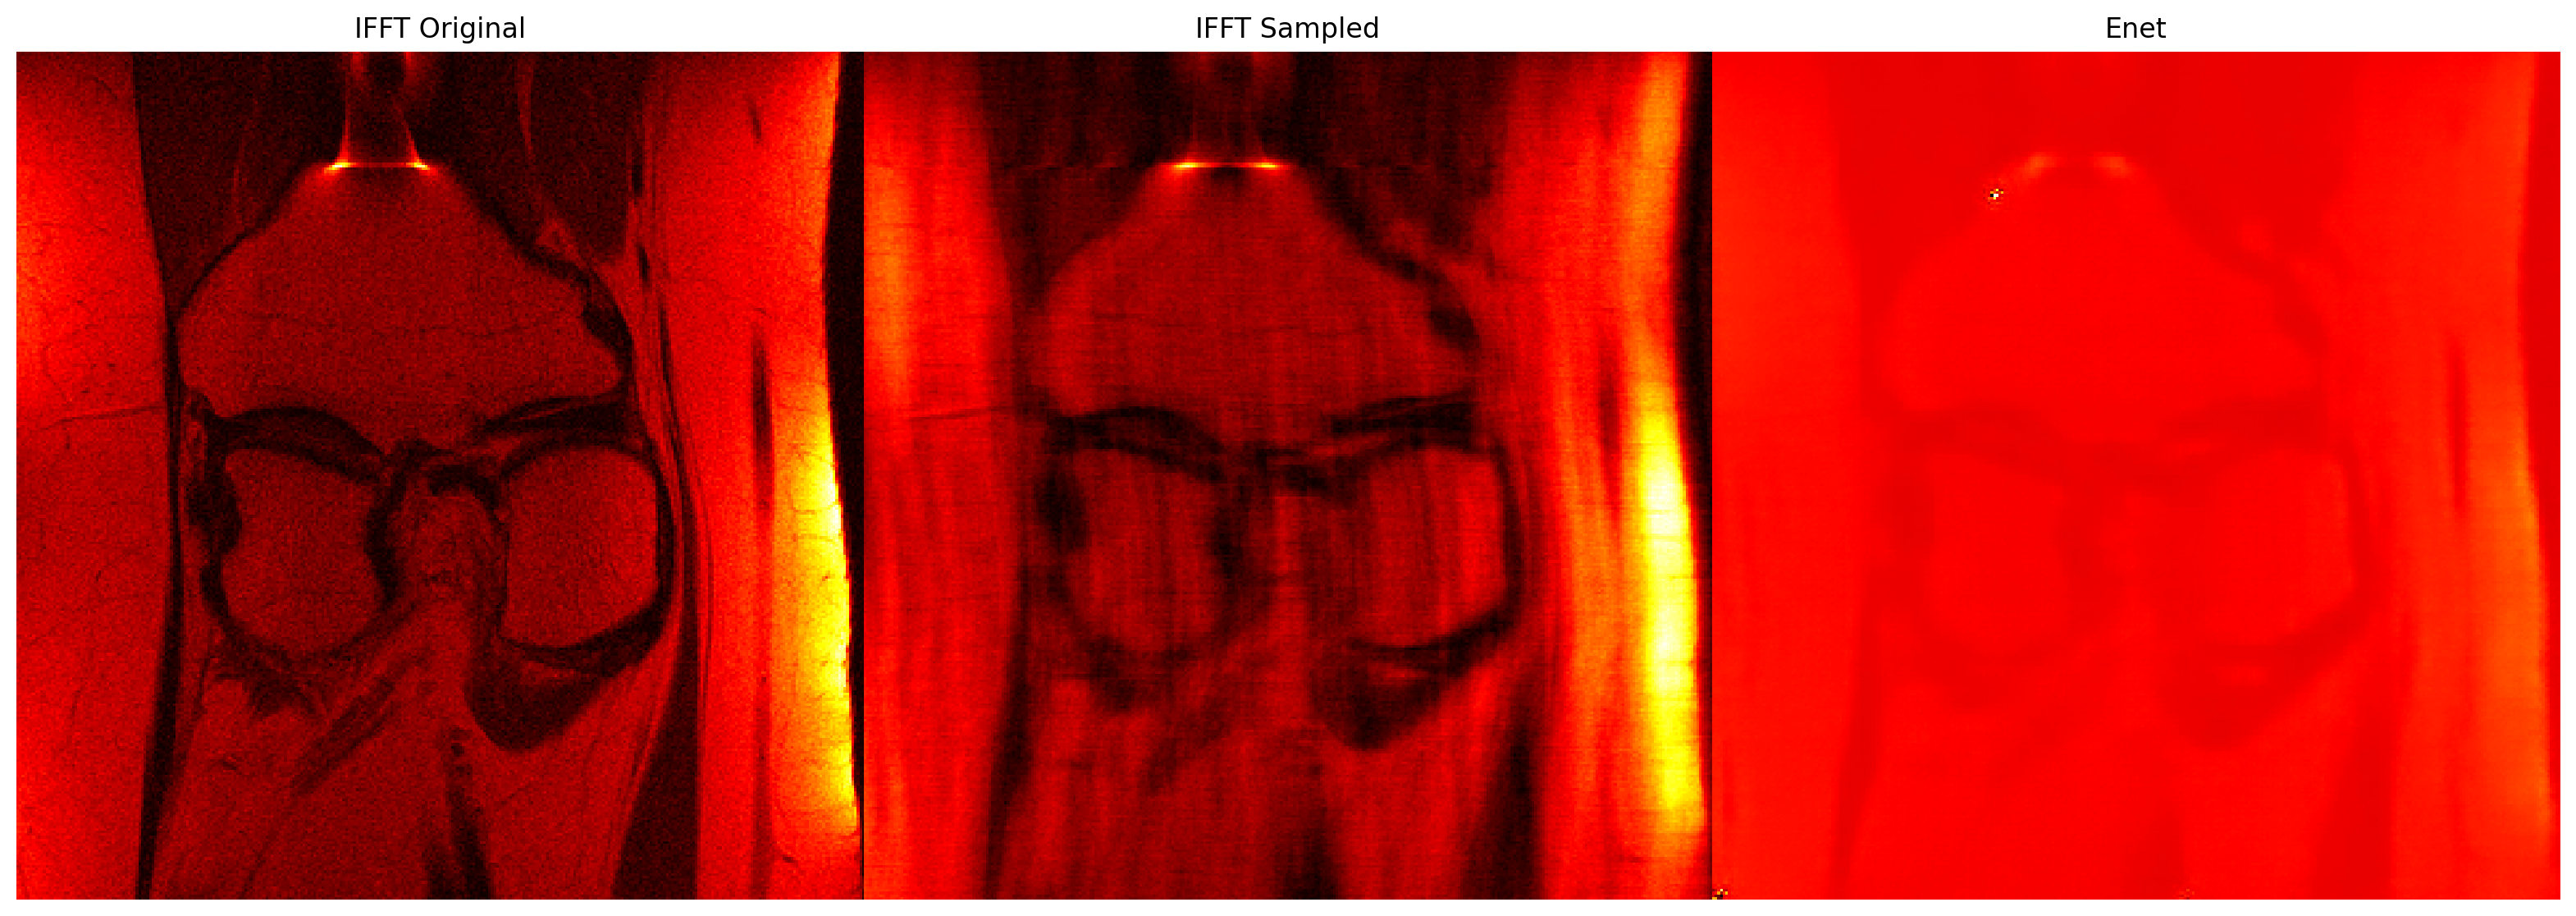

In [7]:
fig, ax = plt.subplots(ncols=2 + len(predictions), dpi=200, figsize=(20,10),
                       subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                       gridspec_kw=dict(wspace=0.0, hspace=0.0))
cm = plt.cm.hot
ax[0].imshow(slice_image_abs, cmap=cm)
ax[0].set_title('IFFT Original')
ax[1].set_title('IFFT Sampled')
ax[1].imshow(sampled_image_abs, cmap=cm)
for i, (p, name) in enumerate(predictions):
    ax[2 + i].imshow(p, cmap=cm)
    ax[2 + i].set_title(name)
plt.show()